In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import matplotlib.patches as patches
from PIL import Image

In [3]:
image_path = '../data/images/'
bbox_path = '../data/bboxes/'

image_list = []
for i in sorted(os.listdir(image_path)):
    image_list.append(image_path+i)
    


bbox_list = []
for i in sorted(os.listdir(bbox_path)):
    h = open(bbox_path+i, 'r') 
    content = h.readlines() 
    bbox = [int(i) for i in content[0].split() if i.isdigit()]
    bbox_list.append(bbox)

# print(bbox_list)        

[16, 20, 620, 436]


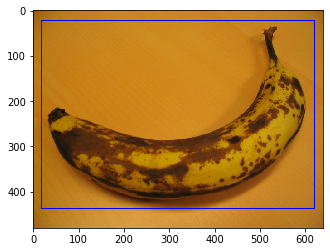

In [4]:
ban_path = image_path + 'banana1.jpg'
ban_bbox = bbox_path + 'banana1.txt'

h = open(ban_bbox, 'r') 
  
content = h.readlines() 
bbox = [int(i) for i in content[0].split() if i.isdigit()]
print(bbox) 


#bbox x1 y1 x2 y2



image = np.array(Image.open(ban_path), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='b',facecolor='none')
# rect = patches.Rectangle((102,55),160,162,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import igraph as ig
import matplotlib.patches as patches
from PIL import Image
import sys
from sklearn.mixture import GaussianMixture 
import time 

def create_lists():

    image_path = '../data/images/'
    bbox_path = '../data/bboxes/'

    image_list = []
    for i in sorted(os.listdir(image_path)):
        image_list.append(image_path+i)



    bbox_list = []
    for i in sorted(os.listdir(bbox_path)):
        h = open(bbox_path+i, 'r') 
        content = h.readlines() 
        bbox = [int(i) for i in content[0].split() if i.isdigit()]
        bbox_list.append(bbox)

    # print(bbox_list)
    return image_list,bbox_list


bbox = [0,0,0,0]
tmp = False
tmp1 = False

def visualise_bbox():
    ban_path = image_path + 'banana1.jpg'
    ban_bbox = bbox_path + 'banana1.txt'

    h = open(ban_bbox, 'r') 

    content = h.readlines() 
    bbox = [int(i) for i in content[0].split() if i.isdigit()]
    print(bbox) 


    #bbox x1 y1 x2 y2



    image = np.array(Image.open(ban_path), dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='b',facecolor='none')
    # rect = patches.Rectangle((102,55),160,162,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

def creating_masks(xmin,ymin,xmax,ymax,r,c,gmm_comps):
    mask = np.zeros((r,c))
    mask = mask.astype('uint8')
    mask[xmin:xmax,ymin:ymax] = 3
    mask_fg = (mask==1)|(mask==3)
    reg_fg = np.where(mask_fg)
    mask_bg = (mask==0)|(mask==2)
    reg_bg = np.where(mask_bg)

    bgd_gmm = GaussianMixture(n_components = gmm_comps)
    fgd_gmm = GaussianMixture(n_components = gmm_comps)
    return mask_fg,mask_bg,bgd_gmm,fgd_gmm,mask

def make_graph(c,r,edges):
    graph = ig.Graph(2 + c * r)
    graph.add_edges(edges)
    return graph    

def make_nlinks(edges,capacity,r,c,V_l,V_ul,V_u,V_ur):
    img_indexes = np.arange(r * c, dtype=np.uint32).reshape(r, c)

    mask1_1 = img_indexes[:, 1:].reshape(-1)
    mask2_1 = img_indexes[:, :-1].reshape(-1)
    edges.extend(list(zip(mask1_1, mask2_1)))

    mask1_2 = img_indexes[1:, :].reshape(-1)
    mask2_2 = img_indexes[:-1, :].reshape(-1)
    edges.extend(list(zip(mask1_2, mask2_2)))

    mask1_3 = img_indexes[1:, 1:].reshape(-1)
    mask2_3 = img_indexes[:-1, :-1].reshape(-1)
    edges.extend(list(zip(mask1_3, mask2_3)))

    mask1_4 = img_indexes[1:, :-1].reshape(-1)
    mask2_4 = img_indexes[:-1, 1:].reshape(-1)
    edges.extend(list(zip(mask1_4, mask2_4)))

    capacity.extend(V_l.reshape(-1).tolist())
    capacity.extend(V_u.reshape(-1).tolist())
    capacity.extend(V_ul.reshape(-1).tolist())
    capacity.extend(V_ur.reshape(-1).tolist())

    graph = make_graph(c,r,edges)

    return capacity,graph

def find_V(gamma,euc_left,euc_upleft,euc_up,euc_upright,beta):
    diag_dist = np.sqrt(np.square(1-0)+np.square(0-0))
    vert_dist = np.sqrt(np.square(1-0)+np.square(0-1))

    V_l = 1/vert_dist *gamma*np.exp(-1*beta*euc_left)
    V_u= 1/vert_dist *gamma*np.exp(-1*beta*euc_up)

    V_ul  = 1/diag_dist *gamma* np.exp(-1*beta*euc_upleft)
    V_ur = 1/diag_dist *gamma* np.exp(-1*beta*euc_upright)

    return V_l,V_ul,V_u,V_ur

def gmm_fitting(image,mask_fg,mask_bg,bgd_gmm,fgd_gmm,mask_reg):

    bgd_gmm.fit(image[mask_bg])

    r=0
    c=0


    fgd_gmm.fit(image[mask_fg])
    
    mask_reg[mask_bg] = bgd_gmm.predict(image[mask_bg])
    r = image.shape[0]

    mask_reg[mask_fg] = fgd_gmm.predict(image[mask_fg])


    bgd_gmm.fit(image[mask_bg], mask_reg[mask_bg])
    c = image.shape[1]


    fgd_gmm.fit(image[mask_fg], mask_reg[mask_fg])

    return mask_fg,mask_bg,bgd_gmm,fgd_gmm,mask_reg

def define_reg():
    return 0,1,2,3

def make_tlinks(mask_reg,source,sink,image,gamma,bgd_gmm,fgd_gmm):
    edges, capacity = [], []

    pr_indexes = np.where((mask_reg.reshape(-1) == 2)|(mask_reg.reshape(-1) == 3))

    edges.extend(
        list(zip([source] * pr_indexes[0].size, pr_indexes[0])))
    D = -1 * bgd_gmm.score_samples(image.reshape(-1, 3)[pr_indexes])
    capacity.extend(D.tolist())

    edges.extend(
        list(zip([sink] * pr_indexes[0].size, pr_indexes[0])))
    D = -1 * fgd_gmm.score_samples(image.reshape(-1, 3)[pr_indexes])

    capacity.extend(D.tolist())


    mask_bg = np.where(mask_reg.reshape(-1) == 0)
    mask_fg = np.where(mask_reg.reshape(-1) == 1)

    edges.extend(list(zip([source] * mask_bg[0].size, mask_bg[0])))
    edges.extend(list(zip([sink] * mask_bg[0].size, mask_bg[0])))

    capacity.extend([0] * mask_bg[0].size)
    capacity.extend([9 * gamma] * mask_bg[0].size)

    edges.extend(list(zip([source] * mask_fg[0].size, mask_fg[0])))
    edges.extend(list(zip([sink] * mask_fg[0].size, mask_fg[0])))

    capacity.extend([9 * gamma] * mask_fg[0].size)
    capacity.extend([0] * mask_fg[0].size)

    return edges,capacity


def GrabCut(im, mask, bbox, gmm_comps=5, num_iter=1):

    gamma = 50

    #Defining Regions
    bg,fg,u_bg,u_fg = define_reg()

    #Bounding box
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]

    #Finding beta
    beta = 0 

    image = np.array(im,dtype=np.float64)
    r = image.shape[0]
    c = image.shape[1]

    euc_left = np.sum(np.square((image[:,1:]-image[:,:-1])),axis=2)
    euc_upleft = np.sum(np.square((image[1:,1:]-image[:-1,:-1])),axis=2)
    euc_up = np.sum(np.square((image[1:,:]-image[:-1,:])),axis=2)
    euc_upright = np.sum(np.square((image[1:,:-1]-image[:-1,1:])),axis=2)

    mean_neigh = (np.sum(euc_upright)+np.sum(euc_upleft)+np.sum(euc_up)+np.sum(euc_left))/(2 + 4*r*c-3*r-3*c)
    beta = 1.0/(2*mean_neigh)

    #Finding Smoothness term 'V'
    V_l,V_ul,V_u,V_ur = find_V(gamma,euc_left,euc_upleft,euc_up,euc_upright,beta)

    #Assigning new Regions
    mask_fg,mask_bg,bgd_gmm,fgd_gmm,mask = creating_masks(xmin,ymin,xmax,ymax,r,c,gmm_comps)

    source = r*c
    i=0
    sink = r*c +1

    mask_reg = np.zeros((r,c),dtype=np.uint32)


    while i < num_iter:

        mask_fg,mask_bg,bgd_gmm,fgd_gmm,mask_reg = gmm_fitting(image,mask_fg,mask_bg,bgd_gmm,fgd_gmm,mask_reg)
        edges,capacity = make_tlinks(mask_reg,source,sink,image,gamma,bgd_gmm,fgd_gmm)
        capacity,graph = make_nlinks(edges,capacity,r,c,V_l,V_ul,V_u,V_ur)
        img_indexes = np.arange(r * c, dtype=np.uint32).reshape(r, c)
        pr_indexes = np.where((mask_reg == 2)|(mask_reg == 3))
        mincut = graph.st_mincut(source, sink, capacity)
        mask_reg[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]),3,2)
        mask_fg = (mask_reg==1)|(mask_reg==3)
        reg_fg = np.where(mask_fg)
        mask_bg = (mask_reg==0)|(mask_reg==2)
        reg_bg = np.where(mask_bg)


        # fgd_indexes, bgd_indexes = classify_pixels(mask)		
        i=i+1
    mask2 = np.where((mask_reg == 1) + (mask_reg == 3), 255, 0).astype('uint8')
    return mask2









In [3]:
def plotter(imglist, rows, cols, title=None):                               
    plt.figure(figsize=(12, 12))
    idx=1
    if title is None:
        title = [i for i in range(0, rows*cols)]
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            img = cv2.imread(imglist[idx-1])
            plt.subplot(rows, cols, idx)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(title[idx-1])
            idx+=1
            plt.axis('off')
    plt.show()
    

# Parameters affecting segmentation

# The number of iterations of GMM updating and energy minimization 

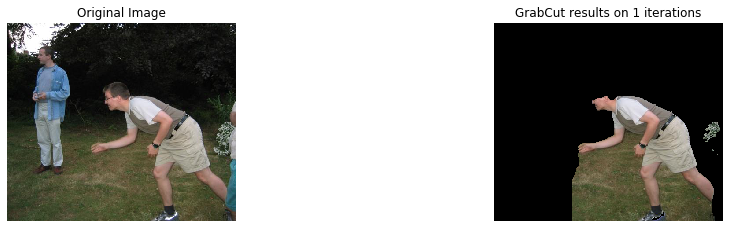

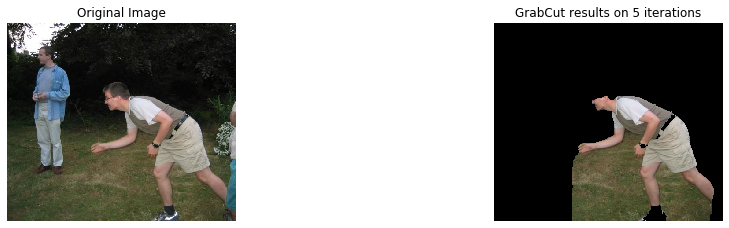

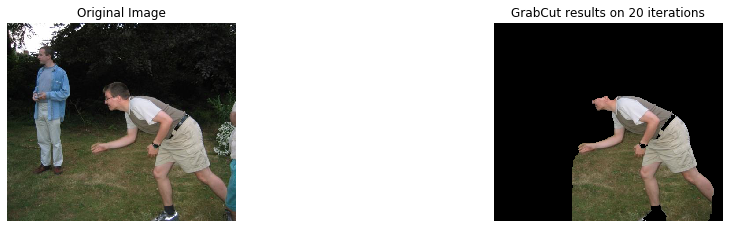

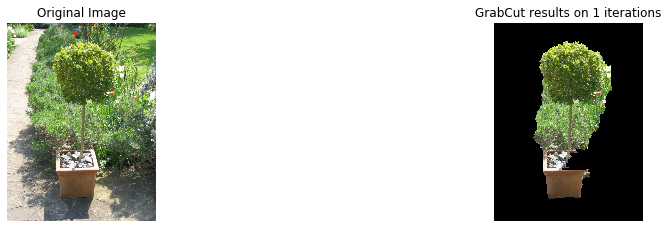

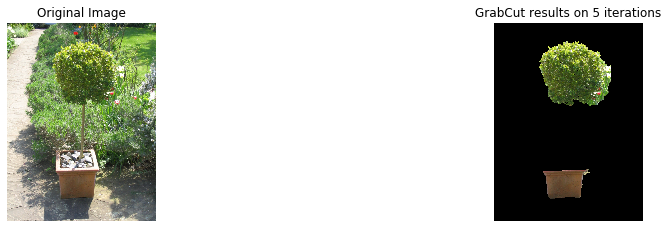

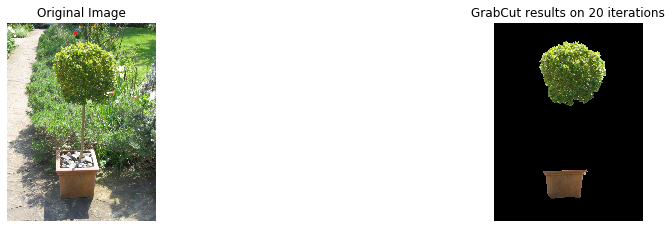

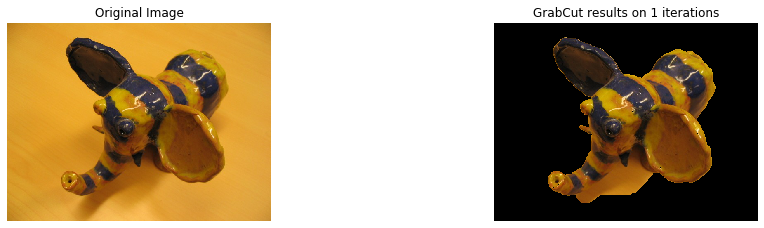

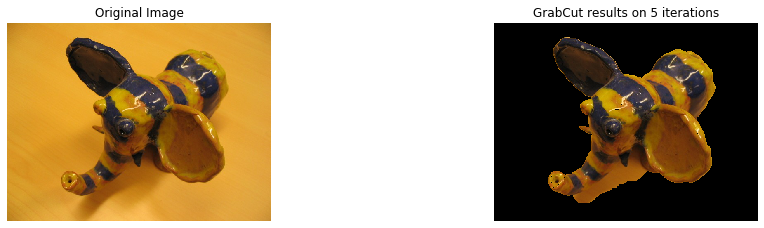

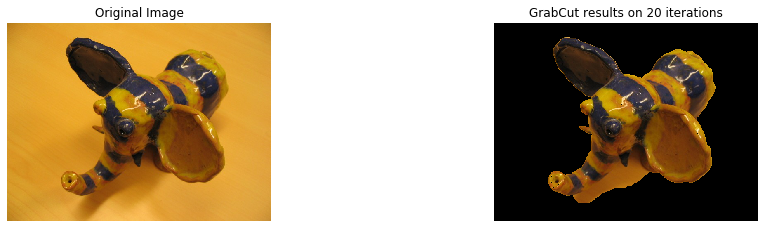

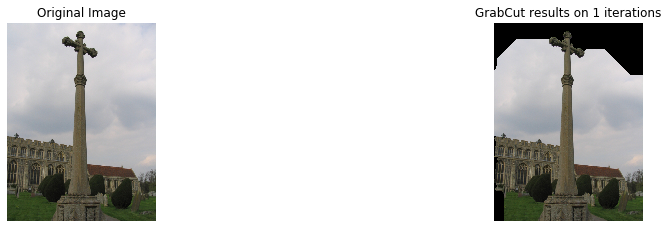

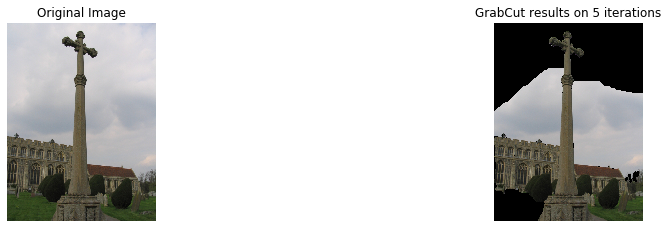

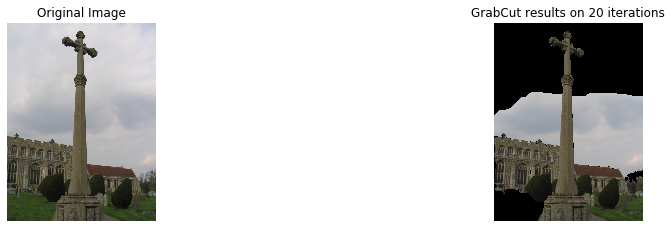

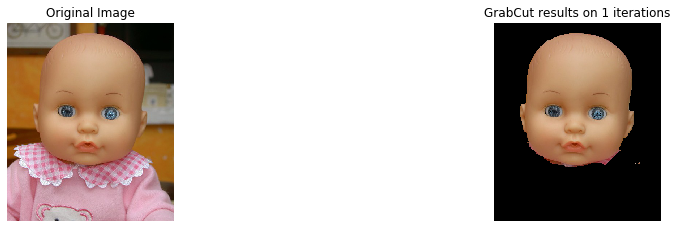

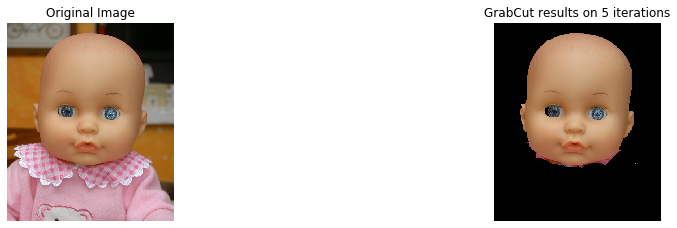

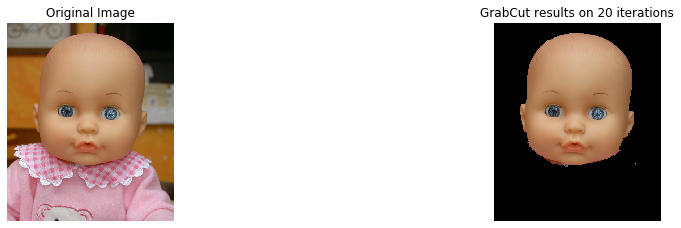

In [25]:
for i in range(4,9):
    img = cv2.imread(image_list[i])
    img = img.astype('uint8')
    x1,y1,x2,y2 = bbox_list[i]
    rect = (x1,y1,x2-x1,y2-y1)
    for iterations in [1,5,20]:            
        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        
        mask, bgdModel, fgdModel = cv2.grabCut(img,mask,rect,bgdModel,fgdModel,iterations,cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        seg_img = img*mask2[:,:,np.newaxis]

        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,2,1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title('Original Image')
        
        ax = fig.add_subplot(2,2,2)
        ax.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title('GrabCut results on {} iterations'.format(iterations))
        
        plt.show()

# The number of mixture components in your GMM

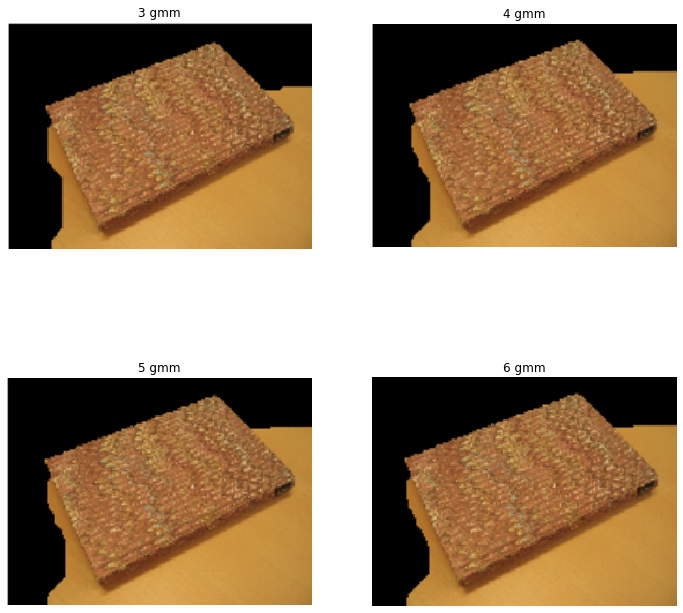

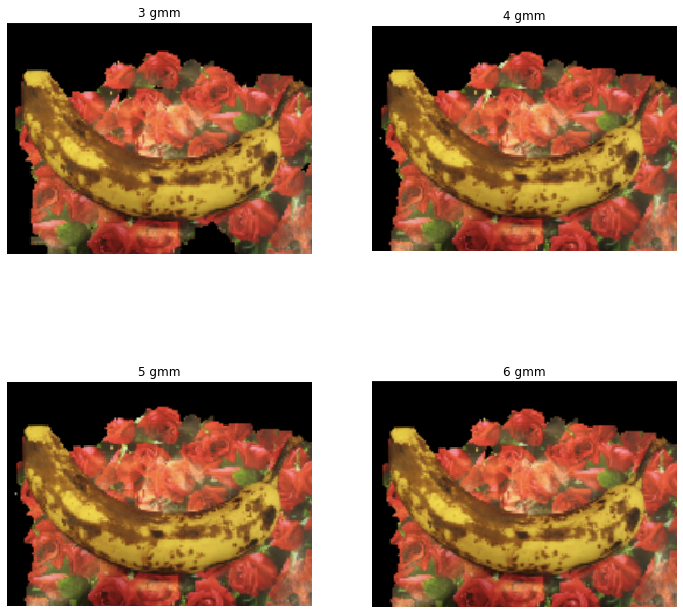

In [39]:
img_list = ["../report/book_gmm/book_gmm_3.png", "../report/book_gmm/book_gmm_4.png", "../report/book_gmm/book_gmm_5.png", "../report/book_gmm/book_gmm_6.png"]
titles = ["3 gmm", "4 gmm","5 gmm", "6 gmm"]
plotter(img_list, 2, 2, title=titles)
img_list = ["../report/banana_gmm/banana_gmm_3.png", "../report/banana_gmm/banana_gmm_4.png", "../report/banana_gmm/banana_gmm_5.png", "../report/banana_gmm/banana_gmm_6.png"]
titles = ["3 gmm", "4 gmm","5 gmm", "6 gmm"]
plotter(img_list, 2, 2, title=titles)

# Different color spaces or ways of representing pixels

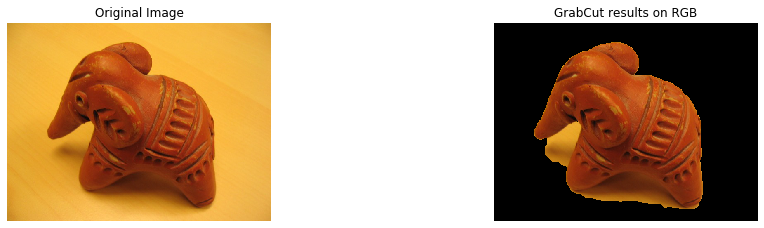

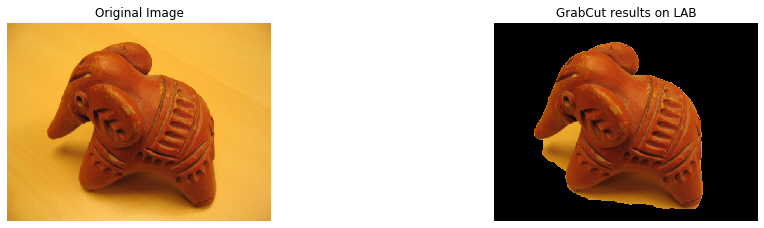

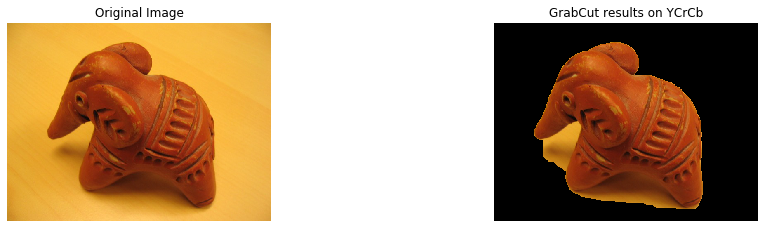

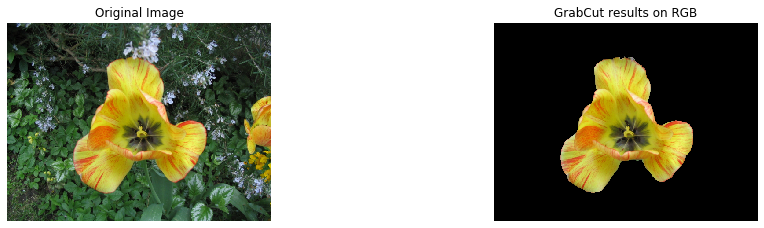

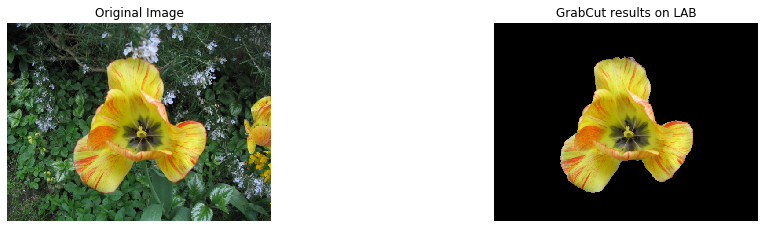

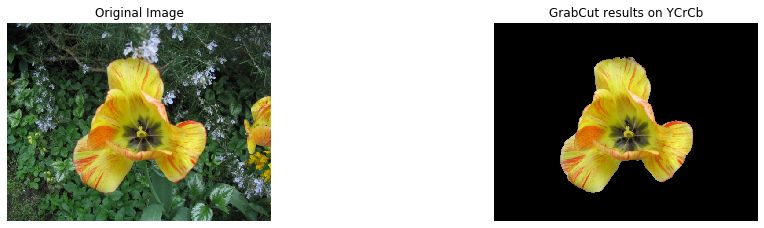

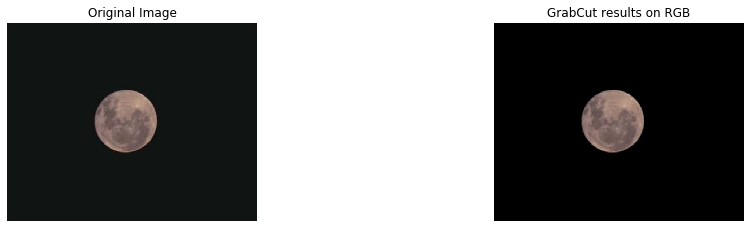

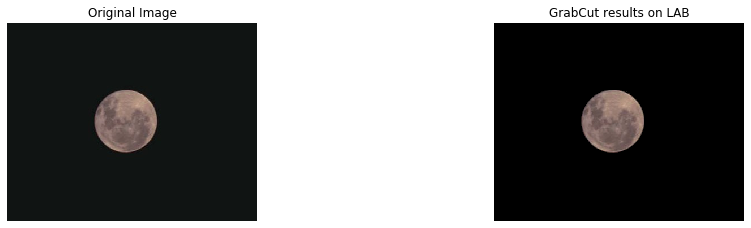

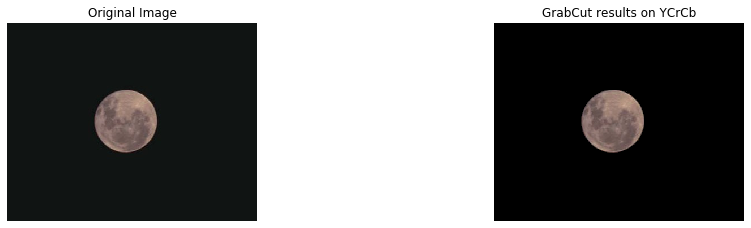

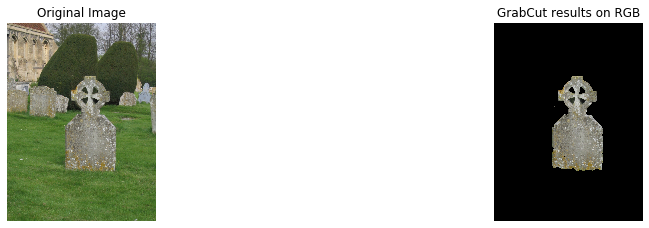

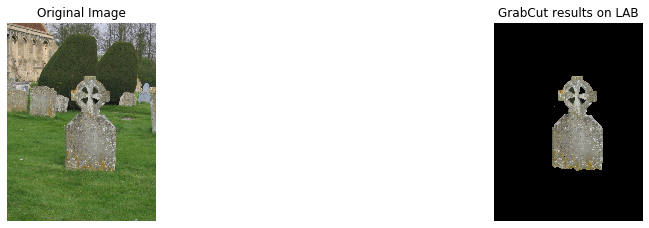

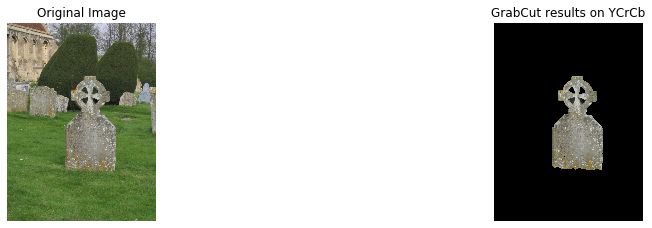

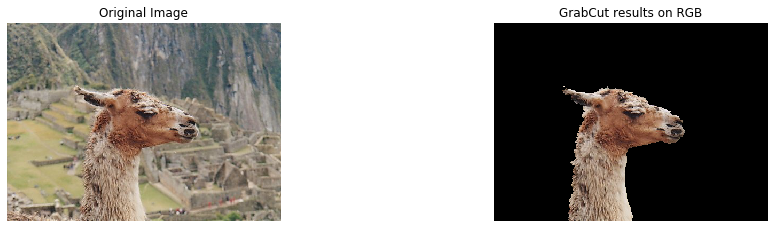

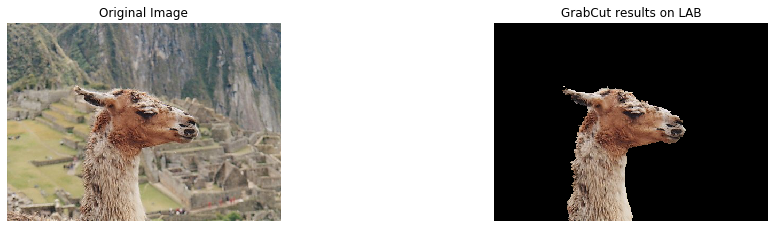

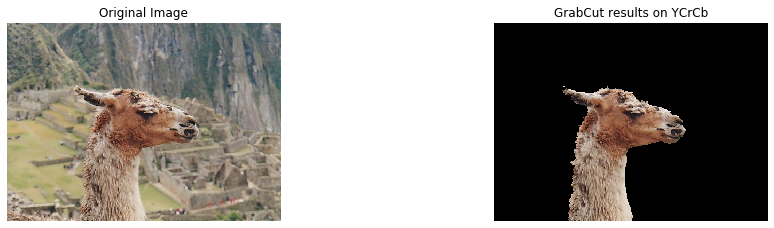

In [33]:
iterations = 4
cname = {
    4: 'RGB',
    44: 'LAB',
    36: 'YCrCb'
}
for i in range(9,14):
    img = cv2.imread(image_list[i])    
    img = img.astype('uint8')
    x1,y1,x2,y2 = bbox_list[i]
    rect = (x1,y1,x2-x1,y2-y1)
    # Color spaces 
    for color_space in [cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2LAB, cv2.COLOR_BGR2YCR_CB]:            
        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        
        mask, bgdModel, fgdModel = cv2.grabCut(cv2.cvtColor(img, color_space),mask,rect,bgdModel,fgdModel,iterations,cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        seg_img = img*mask2[:,:,np.newaxis]

        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,2,1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title('Original Image')
        
        ax = fig.add_subplot(2,2,2)
        ax.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title('GrabCut results on ' + cname[color_space])
        
        plt.show()

# 4-neighborhood or 8-neighborhood

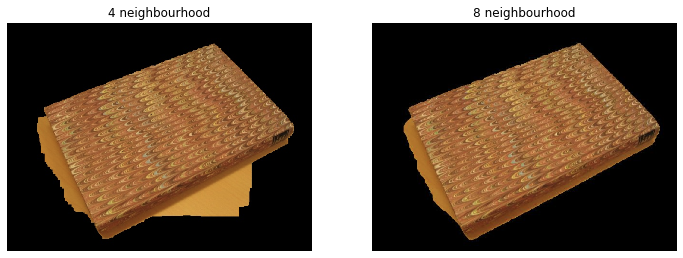

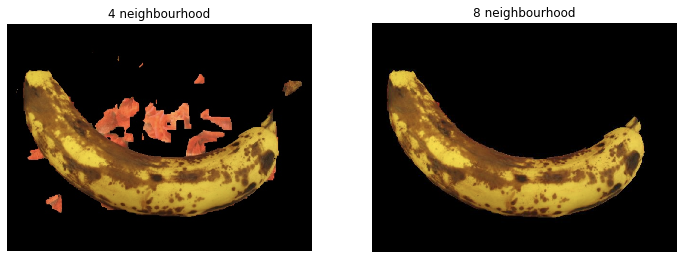

In [36]:
img_list = ["../report/4_neigh/book.jpg", "../report/8_neigh/book.jpg"]
titles = ["4 neighbourhood", "8 neighbourhood"]
plotter(img_list, 1, 2, title=titles)
img_list = ["../report/4_neigh/banana3.jpg", "../report/8_neigh/banana3.jpg"]
titles = ["4 neighbourhood", "8 neighbourhood"]
plotter(img_list, 1, 2, title=titles)

# Tight vs Loose Bounding Boxes

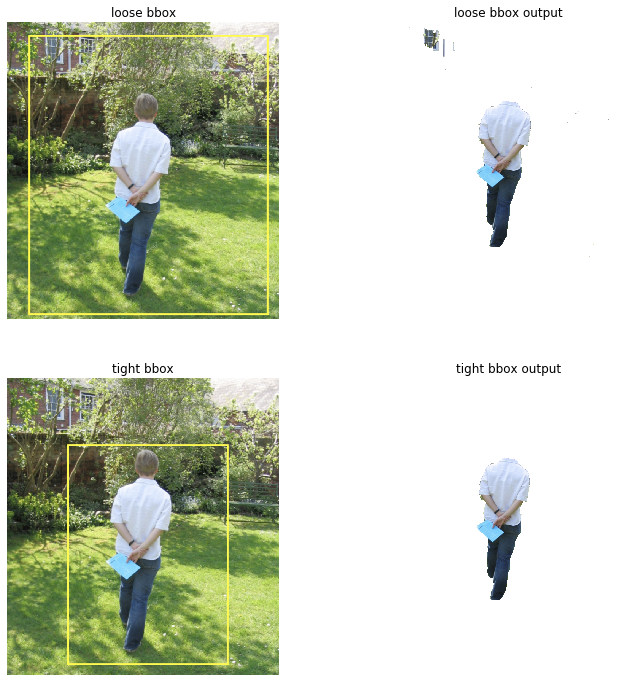

In [40]:
img_list = ["../report/person_loose.jpg", "../report/person_loose_o.jpg","../report/person_tight.jpg", "../report/person_tight_o.jpg"]
titles = ["loose bbox", "loose bbox output","tight bbox", "tight bbox output"]
plotter(img_list, 2, 2, title=titles)
# img_list = ["../report/person_loose_o.jpg", "../report/person_loose_o.jpg"]
# titles = ["4 neighbourhood", "8 neighbourhood"]
# plotter(img_list, 1, 2, title=titles)

# Stereo Matching using Markov Random Field 

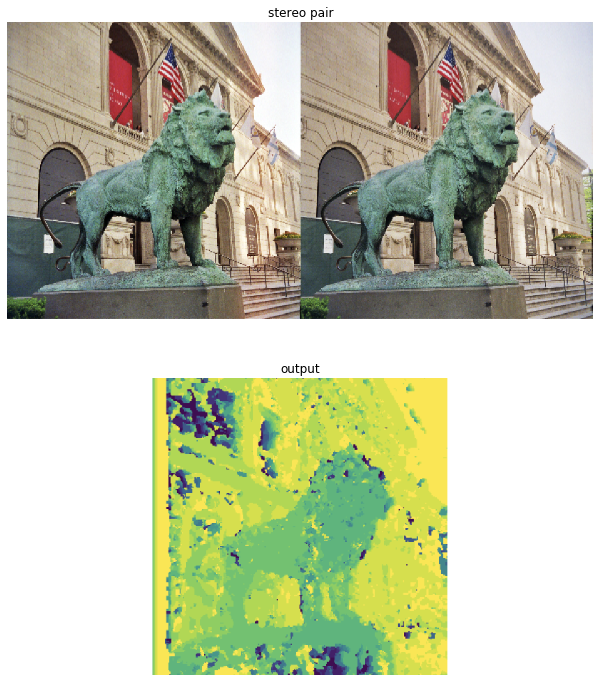

In [6]:
img_list = ["../report/stereo_pair.jpg", "../report/mrf_output.jpg"]
titles = ["stereo pair", "output"]
plotter(img_list, 2, 1, title=titles)

To calculate MRF, we use loopy belief propagation.Belief propagation is a message-passing algorithm for performing inference on graphical models, such as Bayesian networks and Markov random fields.
It calculates the marginal distribution for each unobserved node, conditional on any observed nodes.
Instead, one initializes all variable messages to 1 and uses the same message definitions above, updating all messages at every iteration (although messages coming from known leaves or tree-structured subgraphs may no longer need updating after sufficient iterations).We can observe that MRF provides good depth/disparity maps(as depth is proportional to the disparity in the image). The green areas are near the observer(less depth) and the yellow areas are further.